<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/resnet34_oracle40000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet34 Oracle with X examples
Note that because the 'car' dataset only has 2460 examples, there are not as many images as the num_examples_name.

This block can be run with no changes.

In [3]:
import fastai
from fastai import *
from fastai.vision import *
import os
# print(fastai.__version__ )

In [4]:
# Definitions
dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
classes = ['neither', 'person', None , 'car']
all_processed_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

In [5]:
train_ids = np.loadtxt(dataset, dtype=(int, int))
train_ids_dict = dict(train_ids)

In [6]:
x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
assert(x_train_ids.shape == y_train_ids.shape)
x_train_ids[0], y_train_ids[0]
print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images.")

There are 77650 images, set(x_train_ids) = 77033 images.


In [7]:
# IMPORTANT: If this cell crashes with an Input/Output error, you just need
#            to restart the kernel and try again until it works.
# fnames = get_image_files(all_processed_imgs_dir)
# labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in fnames]
# print(f"There are {len(labels)} labels.")


# Get dataset_X from zip


# You need to change lines here to get the specific dataset.
Download the .zip of your images into Colab's directory, not
into My Drive (your mounted Google Drive).

In [11]:

# !apt install unzip
# !mkdir dataset_X

######################### 
# CHANGE HERE
######################### 
num_examples_name = '40000'
######################### 

dataset_X_parent = '/content/dataset_' + num_examples_name
dataset_X = '/content/dataset_' + num_examples_name + '/processed_subset' + num_examples_name
# os.mkdir(dataset_X_parent)  # Uncomment if directory doesn't exist
!unzip /content/processed_subset40000.zip -d dataset_40000

Streaming output truncated to the last 5000 lines.
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000330611.jpg  
  inflating: dataset_40000/processed_subset40000/000000431026.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000431026.jpg  
  inflating: dataset_40000/processed_subset40000/000000581929.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000581929.jpg  
  inflating: dataset_40000/processed_subset40000/000000107011.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000107011.jpg  
  inflating: dataset_40000/processed_subset40000/000000319283.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000319283.jpg  
  inflating: dataset_40000/processed_subset40000/000000081274.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000081274.jpg  
  inflating: dataset_40000/processed_subset40000/000000226701.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._0000002

In [12]:
dataset_X_ids = {}
for entry in os.scandir(dataset_X):
  if os.path.basename(entry)[0] == '.':
    continue
  dataset_X_ids[int(os.path.basename(entry)[:-4])] = train_ids_dict[int(os.path.basename(entry)[:-4])]
len(dataset_X_ids)

65534

In [13]:
dataset_X_fnames = get_image_files(dataset_X)
dataset_X_labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in dataset_X_fnames]
print(len(dataset_X_labels))

65534


# FastAI

## Make databunch_X
Here we have a 90/10 train/dev split

In [14]:
databunch_X = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels, valid_pct=0.1).normalize(imagenet_stats)
# print(databunch_X)

([0, 1, 3], 3, 58981, 6553)

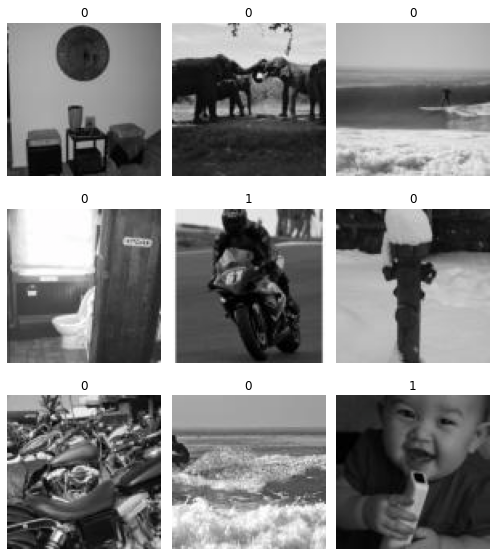

In [15]:
np.random.seed(42)

databunch_X.show_batch(rows=3, figsize=(7,8))
databunch_X.classes, databunch_X.c, len(databunch_X.train_ds), len(databunch_X.valid_ds)

## Stage 1

In [16]:
learner_X = cnn_learner(databunch_X, models.resnet34, metrics=[error_rate, accuracy])

In [17]:
learner_X.fit_one_cycle(40)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.781737,0.569621,0.229818,0.770182,00:53
1,0.594835,0.515876,0.208607,0.791393,00:55
2,0.528810,0.477396,0.196551,0.803449,00:54
3,0.488655,0.453624,0.179765,0.820235,00:55
4,0.462952,0.426772,0.168930,0.831070,00:54
5,0.461960,0.419535,0.164810,0.835190,00:54
6,0.417192,0.411209,0.158706,0.841294,00:54
7,0.413164,0.392467,0.154586,0.845414,00:54
8,0.385572,0.387082,0.150771,0.849229,00:54
9,0.387024,0.384852,0.148482,0.851518,00:54


In [18]:
learner_X.save('learner' + num_examples_name + 'stage-1')


In [19]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()

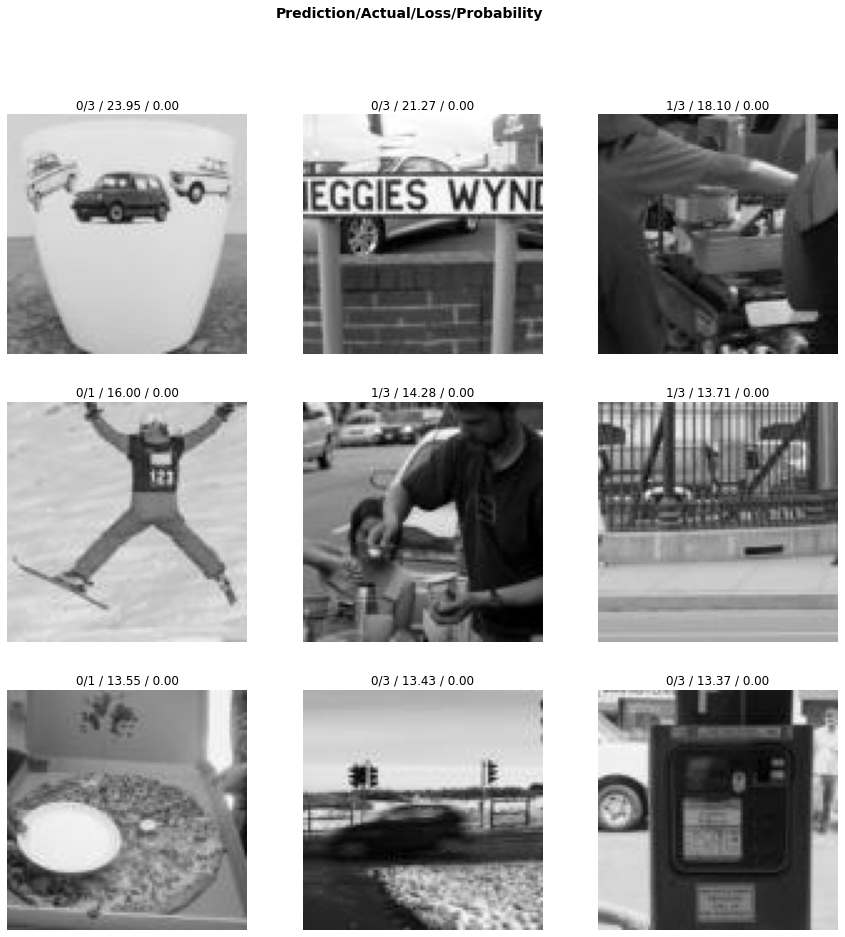

In [20]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)


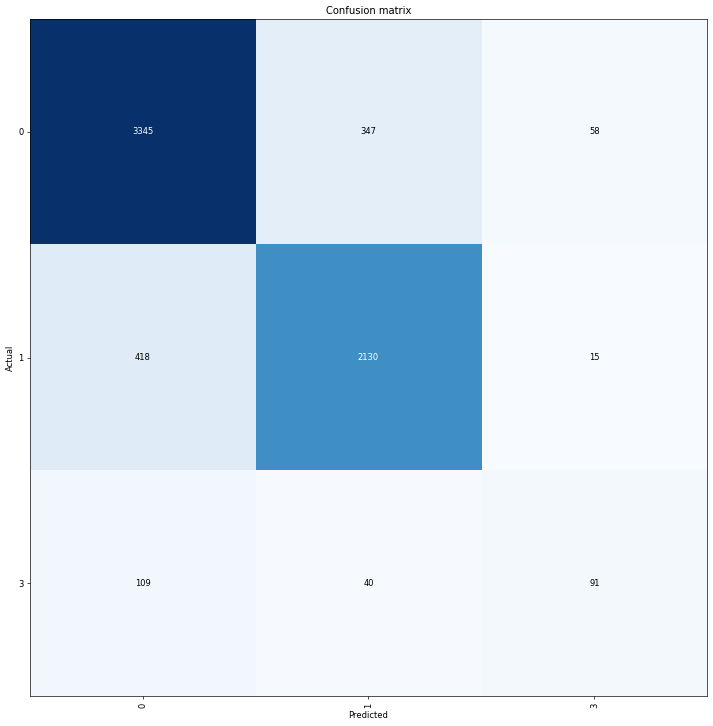

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Stage 2

In [22]:
learner_X.load('learner' + num_examples_name + 'stage-1');

In [23]:
learner_X.unfreeze()

In [24]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


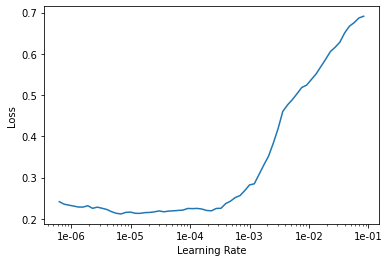

In [25]:
learner_X.recorder.plot()


In [26]:
learner_X.fit_one_cycle(20, max_lr=slice(3e-6,3e-4))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230977,0.476407,0.147719,0.852281,01:19
1,0.200528,0.477081,0.149702,0.850298,01:19
2,0.203049,0.481097,0.146650,0.853350,01:19
3,0.187799,0.509734,0.147108,0.852892,01:19
4,0.152815,0.550223,0.147871,0.852129,01:19
5,0.121599,0.599487,0.148634,0.851366,01:19
6,0.104067,0.661293,0.150618,0.849382,01:19
7,0.080022,0.734929,0.154891,0.845109,01:19
8,0.049957,0.783082,0.161911,0.838089,01:19
9,0.041070,0.821087,0.153060,0.846940,01:19


In [27]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


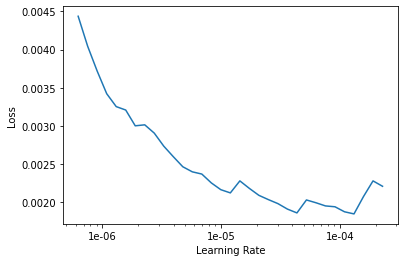

In [29]:
learner_X.recorder.plot()


In [30]:
learner_X.save('learner' + num_examples_name + 'stage-2')


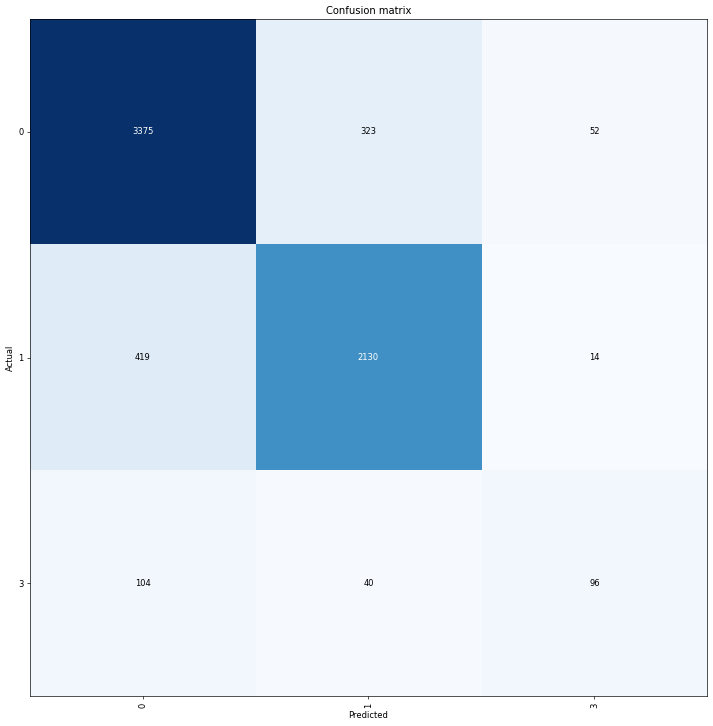

In [31]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
learner_X.fit_one_cycle(20, max_lr=slice(1e-6,5e-5))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.001632,1.051841,0.141004,0.858996,01:19
1,0.002276,1.032920,0.143293,0.856707,01:19
2,0.001486,1.056362,0.141004,0.858996,01:19
3,0.001949,1.079918,0.145735,0.854265,01:19
4,0.001675,1.110822,0.148176,0.851824,01:19
5,0.001145,1.115458,0.143141,0.856859,01:19
6,0.001326,1.138607,0.142683,0.857317,01:19
7,0.002613,1.166309,0.143904,0.856096,01:19
8,0.002137,1.166292,0.143446,0.856554,01:19
9,0.000837,1.197685,0.146956,0.853044,01:19


In [50]:
learner_X.export('/content/learner_40000.pkl')

## Cleanup dataset_X
It turns out that MSCOCO is not that great a dataset, so here's a widget that helps you clean the dataset.

In [33]:
from fastai.widgets import *

In [34]:
databunch_X_clean = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels)


In [35]:
learn_clean_X = cnn_learner(databunch_X_clean, models.resnet34, metrics=error_rate)

learn_clean_X.load('learner' + num_examples_name + 'stage-2');

In [36]:
ds_formatter_X, idxs_formatter_X = DatasetFormatter().from_toplosses(learn_clean_X)

In [37]:
ImageCleaner(ds_formatter_X, idxs_formatter_X, dataset_X)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

([0, 1, 3], 3, 47179, 5242)

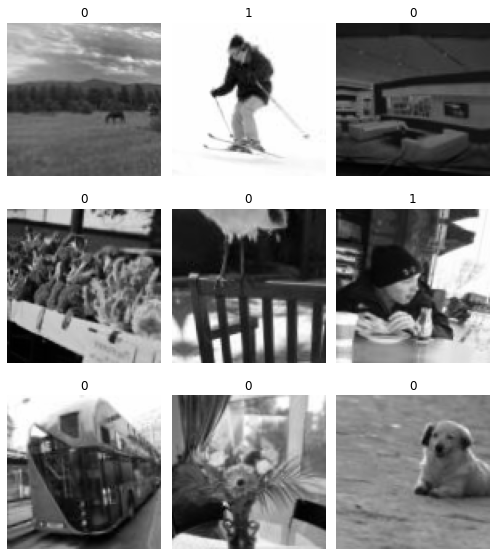

In [38]:
np.random.seed(42)
dataset_X_clean = ImageDataBunch.from_csv(dataset_X, folder=".", valid_pct=0.1, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=96, num_workers=4).normalize(imagenet_stats)

dataset_X_clean.classes

dataset_X_clean.show_batch(rows=3, figsize=(7,8))
dataset_X_clean.classes, dataset_X_clean.c, len(dataset_X_clean.train_ds), len(dataset_X_clean.valid_ds)

In [39]:
learn_clean_X = cnn_learner(dataset_X_clean, models.resnet34, metrics=[error_rate, accuracy])

In [40]:
learn_clean_X.fit_one_cycle(20, max_lr=3e-3)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.723430,0.535861,0.200114,0.799886,01:53
1,0.504158,0.434013,0.172453,0.827547,01:49
2,0.455963,0.400128,0.159672,0.840328,01:48
3,0.463984,0.431072,0.160244,0.839756,01:46
4,0.466781,0.411790,0.161580,0.838420,01:44
5,0.446320,0.409219,0.160435,0.839565,01:44
6,0.426598,0.399733,0.154330,0.845670,01:49
7,0.430088,0.389786,0.158718,0.841282,01:49
8,0.413976,0.389286,0.152423,0.847577,01:48
9,0.422413,0.385660,0.152614,0.847386,01:45


In [43]:
learn_clean_X.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


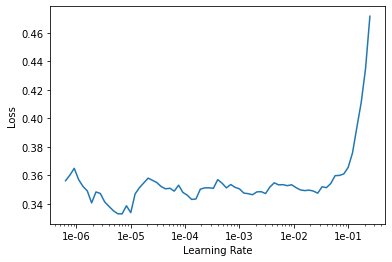

In [44]:
learn_clean_X.recorder.plot()

In [45]:
learn_clean_X.fit_one_cycle(20, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.366614,0.358193,0.133537,0.866463,01:51
1,0.372608,0.362532,0.140595,0.859405,01:47
2,0.360609,0.374408,0.148226,0.851774,01:44
3,0.374149,0.388442,0.151850,0.848150,01:43
4,0.411862,0.393806,0.157001,0.842999,01:44
5,0.401552,0.386451,0.150706,0.849294,01:44
6,0.400500,0.400001,0.155857,0.844143,01:43
7,0.388301,0.372916,0.145746,0.854254,01:43
8,0.397595,0.379353,0.146127,0.853873,01:42
9,0.399953,0.369922,0.139260,0.860740,01:43


In [46]:
learn_clean_X.export()

In [49]:
learn_clean_X.export('/content/learn_clean_40000.pkl')

In [51]:
# !cp /content/learner_40000.pkl /content/drive/My\ Drive/Haptic\ Vest